# 한글설정

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumGothicCoding')

# 데이터 가져오기

In [14]:
import os
import gdown

id = "10Hpa4YM0KX_Ig0W9w7DbTdq62nF2UThA"
output = "./open.zip"

if not os.path.isdir('./datasets'):
  gdown.download(id=id, output=output)
  gdown.extractall(path=output, to='./datasets')

# 데이터프레임 만들기

In [15]:
import os
import glob
import pandas as pd
from collections import defaultdict

raw_data = defaultdict(pd.DataFrame)

for fname in glob.glob('./**/*.csv', recursive=True):
    df_name = os.path.splitext(os.path.basename(fname))[0]
    raw_data[df_name] = pd.read_csv(fname)

* 정상(Normal)과 불량(Error) 데이터 분리

In [16]:
train = raw_data['train'].copy()
train['Status'] = 'Normal'
for idx, val in raw_data['y_feature_spec_info'].iterrows():
    train.loc[(train[val['Feature']] < val['최소']) | (train[val['Feature']] > val['최대']), ['Status']] = 'Error'

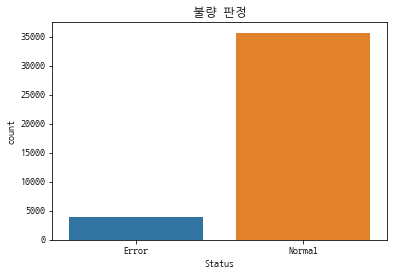

In [17]:
import seaborn as sns

sns.countplot(x='Status', data=train)
plt.title('불량 판정')
plt.show()

* Index에 따라 불량률이 올라갈까?

In [18]:
train_err = train[train['Status'] == 'Error'][['ID', 'Status']].copy()
train_err['IDX'] = train_err['ID'].index // 400
train_err.head()

,ID,Status,IDX
0,TRAIN_00001,Error,0
6,TRAIN_00007,Error,0
9,TRAIN_00010,Error,0
12,TRAIN_00013,Error,0
14,TRAIN_00015,Error,0


<AxesSubplot:xlabel='IDX', ylabel='count'>

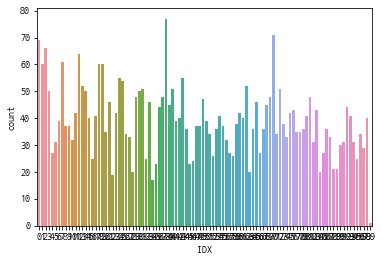

In [19]:
# train_err_g = train_err.groupby(['IDX']).count().drop(columns=['Status']).copy()
sns.countplot(x='IDX', data=train_err)

# Outlier 찾기
* IsolationForest를 이용하여 Outlier 찾기

In [68]:
columns = [ 'X_01', 'X_03', 'X_05', 'X_06', 'X_07', 'X_08', 'X_09' #, 'X_10', 'X_11'
          , 'X_14', 'X_15', 'X_16', 'X_17', 'X_18', 'X_19', 'X_20'
          , 'X_22', 'X_26', 'X_28', 'X_29'
          , 'X_31', 'X_32', 'X_33', 'X_38'
          , 'X_42', 'X_44', 'X_45', 'X_46', 'X_49']

train_outlier = train[columns].copy()
train_outlier.head()

,X_01,X_03,X_05,X_06,X_07,X_08,X_09,X_14,X_15,X_16,...,X_29,X_31,X_32,X_33,X_38,X_42,X_44,X_45,X_46,X_49
0,70.544,67.47,101.892,74.983,29.45,62.38,245.71,13.34,13.37,13.40,...,2.35,1.69,1.46,1.74,-16.41,20.99,21.09,0.29,1463,9706.03
1,69.524,65.17,101.944,72.943,28.73,61.23,233.61,13.33,13.33,13.46,...,2.28,1.67,1.45,1.66,-16.06,21.03,21.13,0.13,1463,10423.43
2,72.583,64.07,103.153,72.943,28.81,105.77,272.20,13.36,13.36,13.39,...,2.26,1.69,1.46,1.68,-16.16,21.03,21.12,0.14,1468,10948.53
3,71.563,67.57,101.971,77.022,28.92,115.21,255.36,13.30,13.33,13.39,...,2.12,1.68,1.47,1.68,-16.05,20.98,21.09,0.22,1469,15007.03
4,69.524,63.57,101.981,70.904,29.68,103.38,241.46,13.35,13.34,13.41,...,2.13,1.68,1.47,1.82,-16.25,20.96,21.10,0.22,1469,11051.03


In [69]:
from sklearn.ensemble import IsolationForest
from collections import Counter, defaultdict

# result = defaultdict(int)

# contamination = 0.00001
# for i in range(1, 10000):
    
#     contamination = 0.00001 * i
#     algorithm = IsolationForest(n_estimators=100, random_state=13, contamination=contamination)
#     outlier = algorithm.fit_predict(train_outlier.to_numpy()) 
#     cnt = Counter(outlier)
#     if cnt[-1] not in result.values():
#         result[i] = cnt[-1]
#         print("IsolationForest[{}]: contamination={:.5f}, count={}".format(i, contamination, cnt[-1]))

#     if len(result) >= 100:
#         break

# result

* Ourlier 100개의 contamination=0.00250

In [70]:
contamination = 0.00250
algorithm = IsolationForest(n_estimators=100, random_state=13, contamination=contamination)
outlier = algorithm.fit_predict(train_outlier.to_numpy()) 

outlier_index = [ i for i, v in enumerate(outlier) if v == -1]
len(outlier), outlier_index[:5]

(39607, [0, 19, 23, 25, 46])

In [71]:
outlier_index  = [ v for v in outlier_index if v not in [70, 280, 6213, 13585, 37911] ]
outlier_index[:2]

[0, 19]

In [72]:
# outlier_list = []
# for i in range(20):
#     outlier_list.append(outlier_index[:(i+1)*5])

# outlier_list[:2]

# Weights & Biases 설정

In [73]:
import wandb

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [74]:
sweep_config = {
    'method': 'grid'
}

metric = {
    'name': 'LG_NRMSE'
}

sweep_config['metric'] = metric

parameters_dict = {
    'drop_index': {
        'value': [ 70, 280, 6213, 13585, 37911 ]
    },
    'outlier': {
        'values': outlier_index
    },
}

sweep_config['parameters'] = parameters_dict

In [75]:
sweep_id = wandb.sweep(sweep_config, project="Antenna_Outlier-1")

Create sweep with ID: nj4jorxe
Sweep URL: https://wandb.ai/zbooster/Antenna_Outlier-1/sweeps/nj4jorxe


# Feature Engineering

## 컬럼 선택

In [76]:
# columns = [ 'X_01', 'X_03', 'X_05', 'X_06', 'X_07', 'X_08', 'X_09', 'X_10'
#           , 'X_11', 'X_14', 'X_15', 'X_16', 'X_17', 'X_18', 'X_19', 'X_20'
#           , 'X_22', 'X_26', 'X_28', 'X_29'
#           , 'X_31', 'X_32', 'X_33', 'X_38'
#           , 'X_42', 'X_44', 'X_45', 'X_46', 'X_49']

## Scaler

In [77]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer

scaler_list = [
    ('Unscaled', None),
    ('Standard', StandardScaler()),
    ('log1p', FunctionTransformer(np.log1p)),
    ('Min-Max', MinMaxScaler()),
    ('Min-Abs', MaxAbsScaler()),
    ('Robust', RobustScaler(quantile_range=(25, 75))),
    ('uniform pdf', QuantileTransformer(output_distribution="uniform")),
    ('gaussian pdf', QuantileTransformer(output_distribution="normal")),
    ('L2 normalizing', Normalizer())
]

# 평가함수

In [78]:
import numpy as np
from sklearn import metrics

# 데이콘에서 제공한 평가함수
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:14])
    return score, all_nrmse

# 학습하기

In [79]:
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from collections import defaultdict

train = raw_data['train'].copy()

def run_train(config=None):
  with wandb.init(config=config):

    config = wandb.config
    train = raw_data['train'].copy()

    # kf = KFold(shuffle=True, random_state=13)
    result = defaultdict(list)

    # Outlier 제거
    drop_index = config.drop_index
    drop_index.append(config.outlier)
    train_out = train.drop(drop_index, axis=0, errors='ignore').copy()
    # train_out = train[config.start_index:].copy()

    # 데이터 나누기
    X = train_out[columns].values
    y = train_out.filter(regex='Y').values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

    
    # for idx, (train_index, test_index) in enumerate(kf.split(X)):

    #   X_train, X_test = X[train_index], X[test_index]
    #   y_train, y_test = y[train_index], y[test_index]

    # 파이프라인 작성
    pipe = make_pipeline( 
      RandomForestRegressor(criterion="squared_error", random_state=13, n_jobs=-1
                          , n_estimators=200 # 반복되는 테스트의 시간을 줄이기 위해 200으로 설정
                          , max_depth=80
                          , min_samples_leaf=2
                          , min_samples_split=2)
    )

    # 학습하기
    pipe.fit(X_train, y_train)

    # 검증하기
    y_pred = pipe.predict(X_test)

    # 평가 및 기록
    score, all_nrmse = lg_nrmse(y_test, y_pred)
    result['LG_NRMSE'].append(score)
    for i, v in enumerate(all_nrmse):
      result['Y_%02d_NRMSE' % (i+1)].append(v)
    
    log_dict = defaultdict(float)
    log_dict['LG_NRMSE_MEAN'] = np.mean(result['LG_NRMSE'])
    log_dict['LG_NRMSE_BEST'] = min(result['LG_NRMSE'])
    for i in range(14):
      log_dict['Y_%02d_NRMSE' % (i+1)] = np.mean(result['Y_%02d_NRMSE' % (i+1)])
    wandb.log(log_dict)

In [80]:
wandb.agent(sweep_id, run_train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Waiting for W&B process to finish... (success).
wandb:                                                                                
wandb: Synced lemon-sweep-1: https://wandb.ai/zbooster/Antenna_Outlier-1/runs/0yfu6ww0
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20220817_061948-0yfu6ww0/logs
wandb: Agent Starting Run: ywurz53v with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 0


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: ERROR Run ywurz53v errored: Error('You must call wandb.init() before wandb.log()')
wandb: Agent Starting Run: 1dtb0h49 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 19


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: vlt0tvzq with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 23


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: vwxtxbn9 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 25


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 0x75tfr9 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 46


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: aze3wxme with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 62


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: jxs1hdzv with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 74


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 0054mfbl with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 76


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: owpa2tjx with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 98


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: uln7ghzp with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 215


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: e3cxr3st with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 219


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 2c25d36v with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 278


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: t0okl8ek with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 865


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: rdtj9d3m with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 1135


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: eub4m3cr with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 1142


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 4phzzlp5 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 1143


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: lrkcjgyu with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 1147


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: jwqcqfuc with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 1240


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 82dkiqzk with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 1334


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 8fn9aso4 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 1442


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fww4rzvf with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 1561


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: jwblxnf3 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2281


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: zvlbltwq with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2327


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: z7om2hpb with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2329


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: od1bl223 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2338


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: w3ra332c with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2346


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: y96fbwzb with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2362


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: vgrpvf8z with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2402


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 83l9hggc with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2416


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 7licq7pr with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2418


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: wc0ojvi0 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2449


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 6xlvcodg with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2452


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 8q47c8ws with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2467


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: wcrfrf1h with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2565


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 9ijk8iv9 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 2569


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ask5ou5u with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 3453


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: k97kot11 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 3454


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6slwveud with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4035


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: raody6fl with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4479


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nqkrwxhj with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4576


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 1okb82tc with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4599


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p18kespe with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4606


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: a4tfzqdr with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4645


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w2tmpw21 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4670


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: o0mnzcgh with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4691


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: fh2vy747 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4703


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: t0fxei4r with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4710


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 7k3uqdh8 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4768


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: szj0njjv with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4769


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 7rzrin34 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4783


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0o9bcqro with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 4787


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: yeqjpol3 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 5817


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vykubfvn with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 6186


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: jud3jlep with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 7155


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uzkq53vw with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 7174


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: vns2nk1r with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 7837


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: un6vjw0e with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 8211


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: skmt5dr5 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 8212


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: bv8vzpeq with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 8412


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 1w3n498k with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 8463


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l96w3elf with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 9276


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: iq5szj86 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 9279


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x5pzsg5e with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 9283


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: d0358gb7 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 9289


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: hqg3glny with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 9299


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: gx3avs4s with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 9321


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 2vzsex1s with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 9345


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: t05wt1cw with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 9377


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7t4qi72h with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 9427


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: f52x13fk with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 9584


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: xzs2os80 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 9749


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rdpz9w3d with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 9775


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 1pelft2u with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 10615


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 4hgsi2wl with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 11617


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: kku1ygcn with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 11622


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: vyzlpbpj with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 11711


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: wrf5tphp with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 11784


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: qpl2x3h6 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 11808


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: qsilayky with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 11812


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: aox4fal0 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 11922


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3d4xhp3e with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 13123


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: fgesj1dc with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 13225


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hgihb786 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 13819


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: eii5mvze with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 15315


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: p70pp8om with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 15486


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: txn5e001 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 16681


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b7g2udd9 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 18100


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 7ac4hfah with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 19870


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cut0z94t with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 20597


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: jxv02eb0 with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 21269


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 4gg2konm with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 23040


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g8fqgcej with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 23196


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: u5texb5l with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 25097


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 81u5r6il with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 25167


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: gl2gmooy with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 25769


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yu8eegdl with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 27304


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1gs0afde with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 32745


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: dne81kir with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 34632


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Agent Starting Run: 54nw2t6c with config:
wandb: 	drop_index: [70, 280, 6213, 13585, 37911]
wandb: 	outlier: 35912


LG_NRMSE_BEST,▁
LG_NRMSE_MEAN,▁
Y_01_NRMSE,▁
Y_02_NRMSE,▁
Y_03_NRMSE,▁
Y_04_NRMSE,▁
Y_05_NRMSE,▁
Y_06_NRMSE,▁
Y_07_NRMSE,▁
Y_08_NRMSE,▁
Y_09_NRMSE,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <function _WandbInit._pause_backend at 0x7efd7c6ee1f0> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe